# [IAPR][iapr]: Coin Detection Project


**Group ID:** 50

**Author 1 (sciper):** Hana Catic (370754)  
**Author 2 (sciper):** Jad Bhamdouni (370746)   

[iapr]: https://github.com/LTS5/iapr/

- folder structure 
- pipe line explanation

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import utils
from collections import Counter

import skimage
from skimage import io
from PIL import Image
from typing import Callable
from skimage.color import rgb2hsv

import warnings
warnings.filterwarnings("ignore")

c:\Users\HanaCatic\anaconda3\envs\iapr\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CoinDataset(Dataset):
    def __init__(self):
        self.labels = pd.read_csv("dataset/train_labels.csv")
        self.root = "dataset/train/"

        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
    
        img_name = os.path.join(self.root, self.labels.iloc[index, 0]+ ".JPG")
        image = io.imread(img_name)
        coins = torch.tensor(self.labels.iloc[index, 1:])
        
        sample = {'image': image, 'coins': coins}
        
        sample = self.transform(sample)
        
        return sample
    
    def transform(self, sample):
        image_og = sample['image'] 

        scale_percent = 50
        width = int(image_og.shape[1] * scale_percent / 100)
        height = int(image_og.shape[0] * scale_percent / 100)
        dim = (width, height)
        image_red = cv2.resize(image_og, dim, interpolation=cv2.INTER_AREA)
        # image_blurred = cv2.medianBlur(image_red, 19)

        return {'image':image_red, 'coins': sample['coins']}
        

def show_image(image, coins):
    plt.imshow(image.squeeze(0))
    plt.pause(0.001)
    
def show_image_batch(coin_batch):
    images_batch = coin_batch['image']
    coins_batch = coin_batch['coins']
    print(len(images_batch))
    
    for i in range(len(images_batch)):
        ax = plt.subplot(1,4, i+1)
        plt.tight_layout()
        ax.set_title('Sample #{}'.format(i))
        ax.axis('off')
        show_image(images_batch[i], coins_batch[i])
    

In [3]:
coin_dataset = CoinDataset()
coin_dataloader = DataLoader(coin_dataset, batch_size=4, shuffle=True, num_workers=0)


## Image segmentation

### Thresholding

In [4]:
def extract_rgb_channels(img):
    """
    Extract RGB channels from the input image.

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    
    Return
    ------
    data_red: np.ndarray (M, N)
        Red channel of input image
    data_green: np.ndarray (M, N)
        Green channel of input image
    data_blue: np.ndarray (M, N)
        Blue channel of input image
    """

    # Get the shape of the input image
    M, N, C = np.shape(img)

    # Define default values for RGB channels
    data_red = np.zeros((M, N))
    data_green = np.zeros((M, N))
    data_blue = np.zeros((M, N))

    # ------------------
    data_red = img[:,:,0]
    data_green = img[:,:,1]
    data_blue = img[:,:,2]
    # ------------------
    
    return data_red, data_green, data_blue

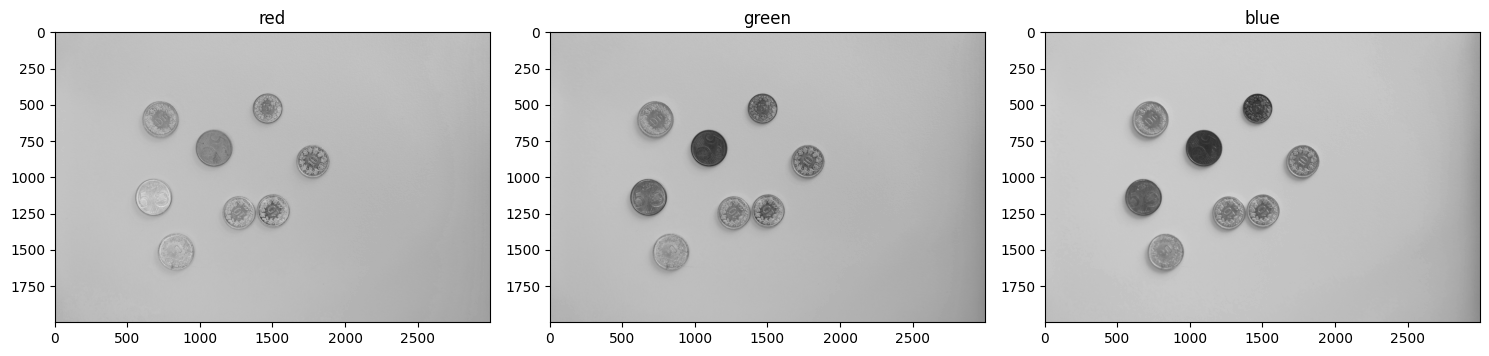

In [5]:
[data_red,data_green,data_blue] = extract_rgb_channels(coin_dataset[0]['image']) # image of coins on neutral background

# Create subplots
plt.figure(figsize=(15, 5))

# Plot the first image
plt.subplot(1, 3, 1)  # 1 row, 3 columns, plot 1
plt.imshow(data_red, cmap='gray')
plt.title('red')

# Plot the second image
plt.subplot(1, 3, 2)  # 1 row, 3 columns, plot 2
plt.imshow(data_green, cmap='gray')
plt.title('green')

# Plot the third image
plt.subplot(1, 3, 3)  # 1 row, 3 columns, plot 3
plt.imshow(data_blue, cmap='gray')
plt.title('blue')

plt.tight_layout()

In [6]:
def apply_rgb_threshold(img):
    """
    Apply threshold to RGB input image.

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    
    Return
    ------
    img_th: np.ndarray (M, N)
        Thresholded image.
    """

    # Define the default value for the input image
    M, N, C = np.shape(img)
    img_th = np.zeros((M, N))

    # Use the previous function to extract RGB channels
    data_red, data_green, data_blue = extract_rgb_channels(img=img)
    
    # ------------------
    thr_green = 163    #   Threshold on green channel
    
    mask_green = data_green > thr_green #   Mask computed on green channel

    img_th = np.logical_not(mask_green)
    # ------------------

    return  img_th

In [7]:
# Plot color space distribution 
def plot_thresholded_image(
    img: np.ndarray,
    func: Callable,
    title: str,
):
    """
    Plot the original image and its thresholded version

    Args
    ----
    img: np.ndarray (M, N, 3)
        Input image of shape MxNx3.
    func: Callable
        Thresholded image.
    title: str
        Title of the plot
    """
    plt.figure()
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].imshow(img)
    axes[1].imshow(func(img))
    [a.axis('off') for a in axes]
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [8]:
def extract_hsv_channels(img):
    """
    Extract HSV channels from the input image.

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    
    Return
    ------
    data_h: np.ndarray (M, N)
        Hue channel of input image
    data_s: np.ndarray (M, N)
        Saturation channel of input image
    data_v: np.ndarray (M, N)
        Value channel of input image
    """

    # Get the shape of the input image
    M, N, C = np.shape(img)

    # Define default values for HSV channels
    data_h = np.zeros((M, N))
    data_s = np.zeros((M, N))
    data_v = np.zeros((M, N))

    # ------------------
    hsv_img = rgb2hsv(img)
    data_h = hsv_img[:,:,0]
    data_s = hsv_img[:,:,1]
    data_v = hsv_img[:,:,2]
    # ------------------
    
    return data_h, data_s, data_v

Text(0.5, 1.0, 'value')

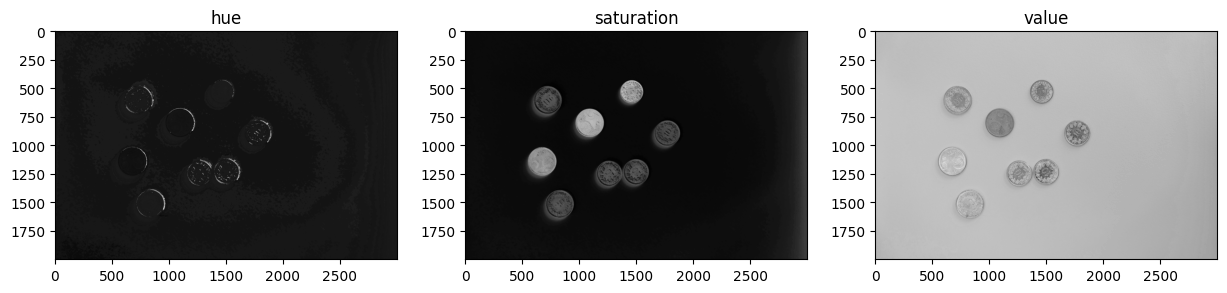

In [9]:
[data_h,data_s,data_v] = extract_hsv_channels(coin_dataset[0]['image'])

# Create subplots
plt.figure(figsize=(15, 5))

# Plot the first image
plt.subplot(1, 3, 1)  # 1 row, 3 columns, plot 1
plt.imshow(data_h, cmap='gray')
plt.title('hue')

# Plot the second image
plt.subplot(1, 3, 2)  # 1 row, 3 columns, plot 2
plt.imshow(data_s, cmap='gray')
plt.title('saturation')

# Plot the third image
plt.subplot(1, 3, 3)  # 1 row, 3 columns, plot 3
plt.imshow(data_v, cmap='gray')
plt.title('value')


<Figure size 640x480 with 0 Axes>

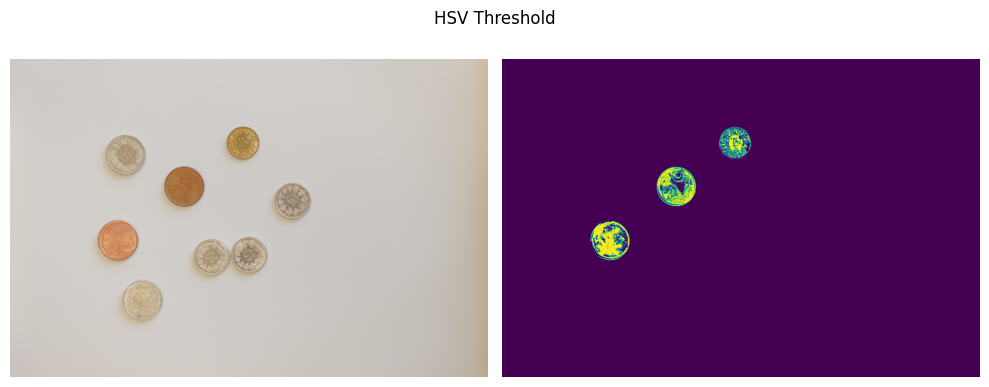

In [10]:
def apply_hsv_threshold(img):
    """
    Apply threshold to the input image in hsv colorspace.

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    
    Return
    ------
    img_th: np.ndarray (M, N)
        Thresholded image.
    """

    # Define the default value for the input image
    M, N, C = np.shape(img)
    img_th = np.zeros((M, N))

    # Use the previous function to extract HSV channels
    data_h, data_s, data_v = extract_hsv_channels(img=img)
    
    # ------------------
    
    thr_s_low = 0.51
    thr_s_up = 0.65 #   Threshold on saturation
    mask_s_low = data_s > thr_s_low   
    mask_s_up = data_s < thr_s_up#   Mask computed on saturation
    img_th = (mask_s_low*mask_s_up)
    
    # ------------------

    return img_th

plot_thresholded_image(img=coin_dataset[0]['image'], func=apply_hsv_threshold, title="HSV Threshold")

In [11]:
def extract_LAB_channels(img):
    """
    Extract HSV channels from the input image.

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    
    Return
    ------
    data_h: np.ndarray (M, N)
        Hue channel of input image
    data_s: np.ndarray (M, N)
        Saturation channel of input image
    data_v: np.ndarray (M, N)
        Value channel of input image
    """

    # Get the shape of the input image
    M, N, C = np.shape(img)

    # ------------------
    LAB_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    L = LAB_img[:,:,0]
    A = LAB_img[:,:,1]
    B = LAB_img[:,:,2]
    # ------------------
    
    return L, A, B

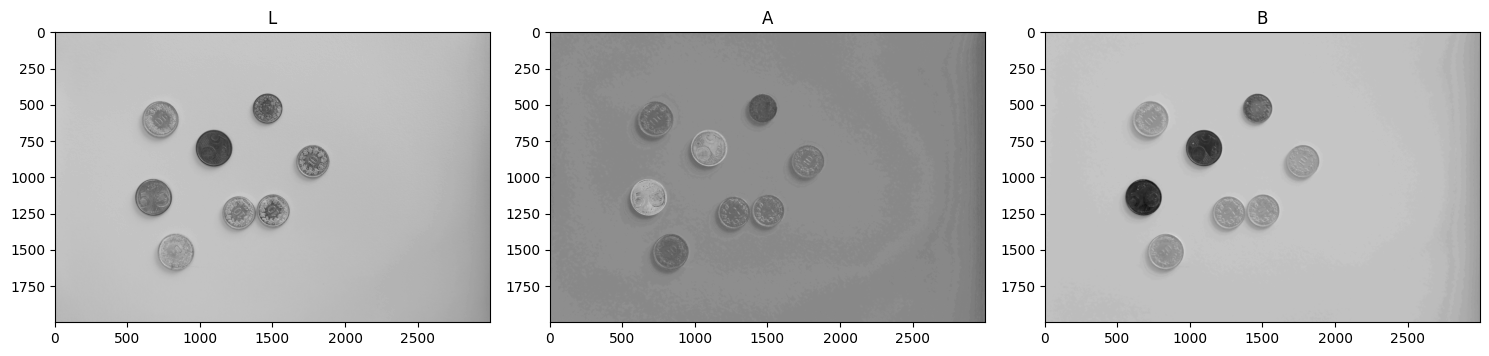

In [12]:
[data_red,data_green,data_blue] = extract_LAB_channels(coin_dataset[0]['image'])

# Create subplots
plt.figure(figsize=(15, 5))

# Plot the first image
plt.subplot(1, 3, 1)  # 1 row, 3 columns, plot 1
plt.imshow(data_red, cmap='gray')
plt.title('L')

# Plot the second image
plt.subplot(1, 3, 2)  # 1 row, 3 columns, plot 2
plt.imshow(data_green, cmap='gray')
plt.title('A')

# Plot the third image
plt.subplot(1, 3, 3)  # 1 row, 3 columns, plot 3
plt.imshow(data_blue, cmap='gray')
plt.title('B')

plt.tight_layout()

In [13]:
def apply_LAB_threshold(img):
    """
    Apply threshold to the input image in hsv colorspace.

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    
    Return
    ------
    img_th: np.ndarray (M, N)
        Thresholded image.
    """

    # Define the default value for the input image
    M, N, C = np.shape(img)
    img_th = np.zeros((M, N))        
    # ------------------

    LAB_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    thr_A = 130      #   Threshold on A channel
    mask_A = LAB_img[:,:,1] > thr_A     #   Mask computed on A channel
    img_th = np.logical_not(mask_A) 
    
    # ------------------
    return  img_th

def apply_LAB_threshold_noisy(img):
    """
    Apply threshold to the input image in hsv colorspace.

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    
    Return
    ------
    img_th: np.ndarray (M, N)
        Thresholded image.
    """

    # Define the default value for the input image
    M, N, C = np.shape(img)
    img_th = np.zeros((M, N))
        
    # ------------------

    LAB_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    thr_B = 107     #   Threshold on B channel
    
    mask_B = LAB_img[:,:,2] > thr_B  
    mask_3 = LAB_img[:,:,2] > 114
    mask_4 = LAB_img[:,:,2] < 117

    img_th = np.logical_or(np.logical_not(mask_B), mask_3*mask_4) #+ np.logical_not(mask_3)
    # ------------------
    return img_th



<Figure size 640x480 with 0 Axes>

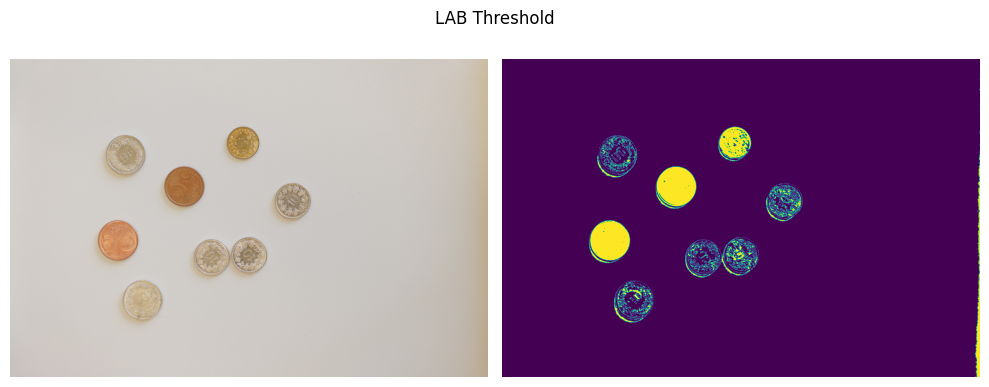

In [14]:
plot_thresholded_image(img=coin_dataset[0]['image'], func=apply_LAB_threshold_noisy, title="LAB Threshold")

In [32]:
def apply_threshold(img):
    # https://stackoverflow.com/questions/70659992/how-to-improve-accuracy-of-cv2s-houghcircles
    image_blurred = cv2.medianBlur(img, 17)
    background = find_background(img)
    neutral_detected, coins = detect_neutral(img)
    hand_detected, hand = detect_hand(img)
    if neutral_detected and background[0] > 180:
        background_type = "neutral"
        img_th = np.logical_not(coins==0)
    elif hand_detected and background[0] > 180:
        background_type = "hand"
        img_th = np.logical_not(np.logical_or(apply_LAB_threshold(img), apply_hsv_threshold(img))) 
    else:
        img_th = apply_LAB_threshold_noisy(image_blurred)
        background_type = "noisy"
    return img_th, background_type

def detect_neutral(img):
    # https://stackoverflow.com/questions/58668245/how-to-quickly-and-efficiently-check-if-an-image-is-mostly-background
    h,w, _ = img.shape
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU+cv2.THRESH_BINARY_INV)[1]
    pixels = cv2.countNonZero(thresh)
    ratio = pixels/(h*w) * 100
    return ratio < 10, thresh

def detect_hand(img):
    h,w, _ = img.shape
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU+cv2.THRESH_BINARY_INV)[1]
    pixels = cv2.countNonZero(thresh)
    ratio = pixels/(h*w) * 100    
    return (ratio < 30), thresh

def find_background(img):
    # https://umarmasud07.medium.com/easiest-approach-for-background-colour-detection-5914217da325
    blue,green,red=cv2.split(img)
    blue=blue.flatten()
    green=green.flatten()
    red=red.flatten()
    blue_counter=Counter(blue)
    green_counter=Counter(green)
    red_counter=Counter(red)
    blue_most=blue_counter.most_common(10)
    blue_avg=[i for i,j in blue_most]
    blue_avg=int(np.mean(blue_avg))
 
    green_most=green_counter.most_common(10)
    green_avg=[i for i,j in green_most]
    green_avg=int(np.mean(green_avg))
    red_most=red_counter.most_common(10)
    red_avg=[i for i,j in red_most]
    red_avg=int(np.mean(red_avg))
    background=[blue_avg,green_avg,red_avg]
    return(background)


<Figure size 640x480 with 0 Axes>

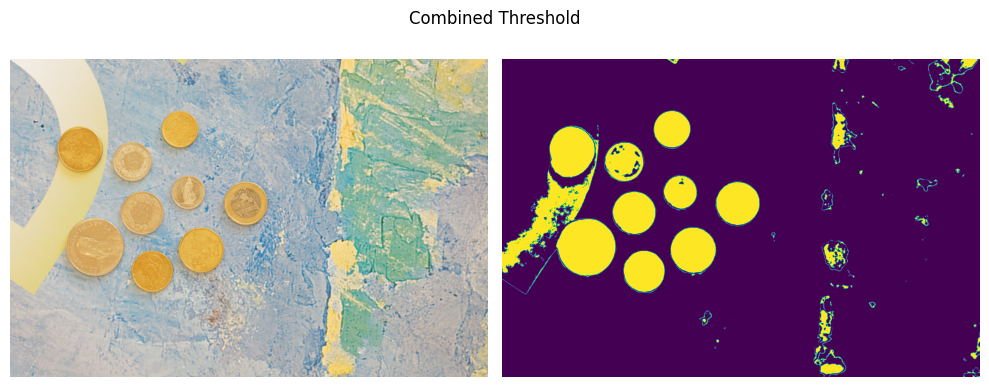

In [30]:
plot_thresholded_image(img=coin_dataset[29]['image'], func=apply_threshold, title="Combined Threshold")

In [17]:
# import random
# list = random.sample(range(0,80),5)
# print(list)
# list = [3, 4, 56,31, 32, 66, 77]
# for i in list:
#     print(i, coin_dataset.labels.iloc[i, 0])
#     plot_thresholded_image(img=coin_dataset[i]['image'], func=apply_threshold, title="Combined Threshold")

In [18]:
def apply_morphology(img_th):
    """
    Apply morphology to thresholded image

    Args
    ----
    img_th: np.ndarray (M, N)
        Image mask of size MxN.

    Return
    ------
    img_morph: np.ndarray (M, N)
        Image after morphological operations
    """

    img_morph = np.zeros_like(img_th)
    
    # ------------------
    img_obj = skimage.morphology.remove_small_objects(img_th, min_size=100, connectivity=1, out=None)
    img_morph = skimage.morphology.remove_small_holes(img_obj, area_threshold=20, connectivity=1, out=None)
    # ------------------
    
    return img_morph

In [19]:
def apply_processing(img):
    """
    Apply morphology to thresholded image

    Args
    ----
    img_th: np.ndarray (M, N)
        Image mask of size MxN.

    Return
    ------
    img_morph: np.ndarray (M, N)
        Image after morphological operations
    """

    img_thr = np.zeros_like(img)
    
    # ------------------
    img_thr, background_type = apply_threshold(img)
    # ------------------
    
    return img_thr, background_type

In [20]:
# import random
# list = random.sample(range(0,80),5)
# print(list)
# # list = [66, 29]
# list = [25, 29, 31, 32, 38, 77, 78, 79]

# for i in list:
#     print(i, coin_dataset.labels.iloc[i, 0])
#     img_th = apply_threshold(img=coin_dataset[i]['image'])
#     plot_thresholded_image(img=img_th, func=apply_morphology, title="Combined Threshold")

In [21]:
# import random
# list = random.sample(range(0,80),5)
# print(list)

# for i in list:
#     print(i, coin_dataset.labels.iloc[i, 0])
#     plot_thresholded_image(img=coin_dataset[i]['image'], func=apply_detection, title="Combined Threshold")

In [24]:
def apply_hough_transform(img):
    
    blur = cv2.GaussianBlur(img, (35,35), cv2.BORDER_DEFAULT) # https://stackoverflow.com/questions/70659992/how-to-improve-accuracy-of-cv2s-houghcircles

    circles = cv2.HoughCircles(blur,cv2.HOUGH_GRADIENT_ALT,1.5,minDist=110, param1=220,param2=0.6, minRadius=75,maxRadius=500)
    print(circles)
    circles = circles[0]
    
    return circles

def get_circles(img):
    img_processed, background_type = apply_processing(img)
    img_processed= img_processed.astype(np.uint8)*255
    circles = apply_hough_transform(img_processed)
    circles = np.uint16(np.around(circles))
    result = []
    for i in range(0, len(circles)):
        add = True
        for j in range(0, len(result)):
            if circles[i][0] == result[j][0] and result[j][1] == circles[i][1]:
                add = False
                if circles[i][2] > result[j][2]:
                    result[j][2] = circles[i][2]
        if add:
            result.append(circles[i])
    return img_processed, result

def crop_image_into_patches(image, circles): #, background_type):
    patches = []
    for i in range(len(circles)):
        current_circle = circles[i]
        current_x = current_circle[0]
        current_y = current_circle[1]
        current_r = current_circle[2]

        # Calculate bounding box coordinates for cropping
        top_left_x = max(0, current_x - current_r)
        top_left_y = max(0, current_y - current_r)
        bottom_right_x = min(image.shape[1], current_x + current_r)
        bottom_right_y = min(image.shape[0], current_y + current_r)

        # Crop circular region
        cropped = image[top_left_y:bottom_right_y, top_left_x:bottom_right_x]
        # if not (np.sum(cropped) > 1500 and background_type == "hand"):
        patches.append(cropped)
            
    return patches

def plot_coins(
    img: np.ndarray,
    func: Callable,
    title: str,
):
    """
    Plot the original image and its thresholded version

    Args
    ----
    img: np.ndarray (M, N, 3)
        Input image of shape MxNx3.
    func: Callable
        Thresholded image.
    title: str
        Title of the plot
    """
    plt.figure()
    print(img.shape)
    processed, circles = func(img)
    fig, ax = plt.subplots()

    ax.imshow(img)

    print("circles: ", circles)

    for i in circles:
        # draw the outer circle
        plt.scatter(i[0],i[1])
        # draw the center of the circle
        circle_obj = plt.Circle((i[0], i[1]), radius=i[2] , fill=False, color='r')
        ax.add_patch(circle_obj)
    plt.tight_layout()
    plt.show()

    return circles
    
# plot_coins(img=image_og, func=get_circles, title="Combined Threshold")

[51, 35, 52, 7, 22, 64, 13, 14, 26, 6]
25 L1010345
(2000, 3000, 3)
[[[1488.        828.        126.444786]
  [1756.5       664.5       125.794106]
  [1509.        421.5       126.69493 ]]]
circles:  [array([1488,  828,  126], dtype=uint16), array([1756,  664,  126], dtype=uint16), array([1509,  422,  127], dtype=uint16)]


<Figure size 640x480 with 0 Axes>

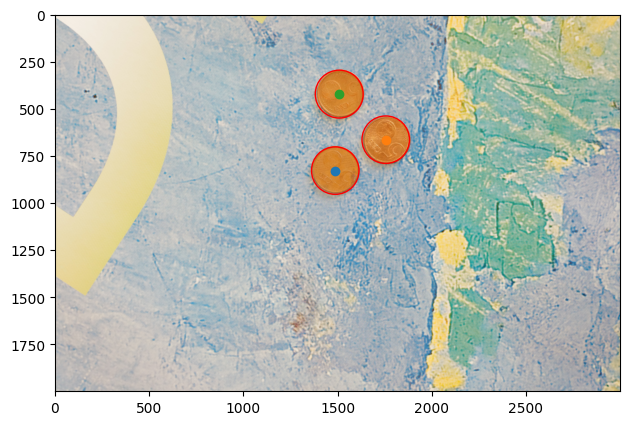

circles:  [array([1488,  828,  126], dtype=uint16), array([1756,  664,  126], dtype=uint16), array([1509,  422,  127], dtype=uint16)]
29 L1010369
(2000, 3000, 3)
[[[ 528.       1185.        180.32536 ]
  [ 433.5       574.5       149.38405 ]
  [1207.5      1201.5       141.44704 ]
  [ 895.5      1341.        129.33972 ]
  [1483.5       910.5       135.25133 ]
  [ 765.        646.5       121.35397 ]
  [ 831.        973.5       133.48311 ]
  [1065.        444.        114.39802 ]
  [1117.5       843.        104.114296]]]
circles:  [array([ 528, 1185,  180], dtype=uint16), array([434, 574, 149], dtype=uint16), array([1208, 1202,  141], dtype=uint16), array([ 896, 1341,  129], dtype=uint16), array([1484,  910,  135], dtype=uint16), array([765, 646, 121], dtype=uint16), array([831, 974, 133], dtype=uint16), array([1065,  444,  114], dtype=uint16), array([1118,  843,  104], dtype=uint16)]


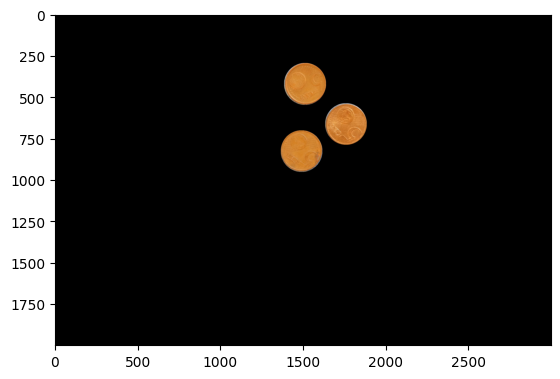

<Figure size 640x480 with 0 Axes>

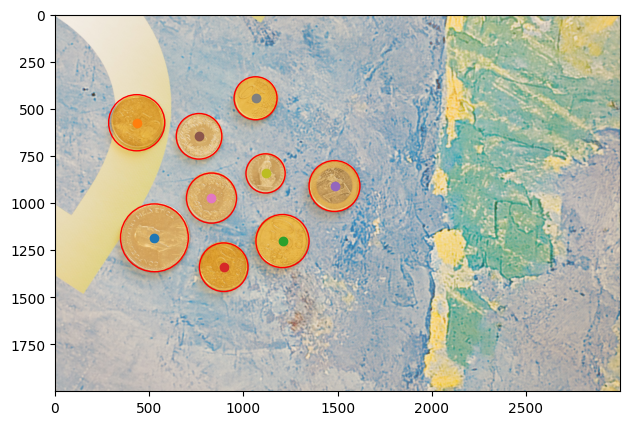

circles:  [array([ 528, 1185,  180], dtype=uint16), array([434, 574, 149], dtype=uint16), array([1208, 1202,  141], dtype=uint16), array([ 896, 1341,  129], dtype=uint16), array([1484,  910,  135], dtype=uint16), array([765, 646, 121], dtype=uint16), array([831, 974, 133], dtype=uint16), array([1065,  444,  114], dtype=uint16), array([1118,  843,  104], dtype=uint16)]
31 L1010395
(2000, 3000, 3)
[[[1581.       973.5      137.68695]
  [1980.      1560.        99.93504]
  [1752.      1339.5      150.77597]
  [1150.5      888.       112.42148]
  [ 964.5      619.5      107.42905]]]
circles:  [array([1581,  974,  138], dtype=uint16), array([1980, 1560,  100], dtype=uint16), array([1752, 1340,  151], dtype=uint16), array([1150,  888,  112], dtype=uint16), array([964, 620, 107], dtype=uint16)]


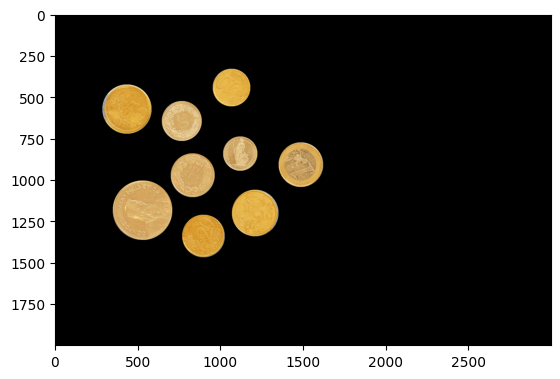

<Figure size 640x480 with 0 Axes>

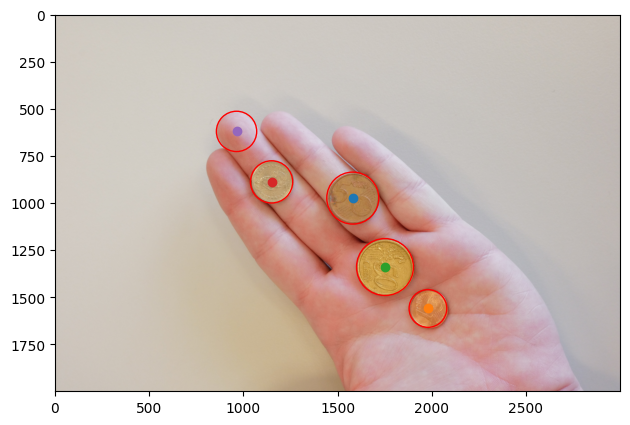

circles:  [array([1581,  974,  138], dtype=uint16), array([1980, 1560,  100], dtype=uint16), array([1752, 1340,  151], dtype=uint16), array([1150,  888,  112], dtype=uint16), array([964, 620, 107], dtype=uint16)]
32 L1010390
(2000, 3000, 3)
[[[1986.        982.5       132.63219 ]
  [1396.5       610.5       145.22014 ]
  [1576.5      1249.5       125.17624 ]
  [1951.5      1390.5       112.271454]
  [1290.        159.        105.92811 ]]]
circles:  [array([1986,  982,  133], dtype=uint16), array([1396,  610,  145], dtype=uint16), array([1576, 1250,  125], dtype=uint16), array([1952, 1390,  112], dtype=uint16), array([1290,  159,  106], dtype=uint16)]


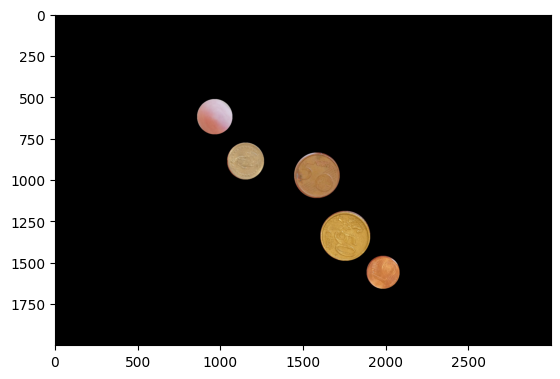

<Figure size 640x480 with 0 Axes>

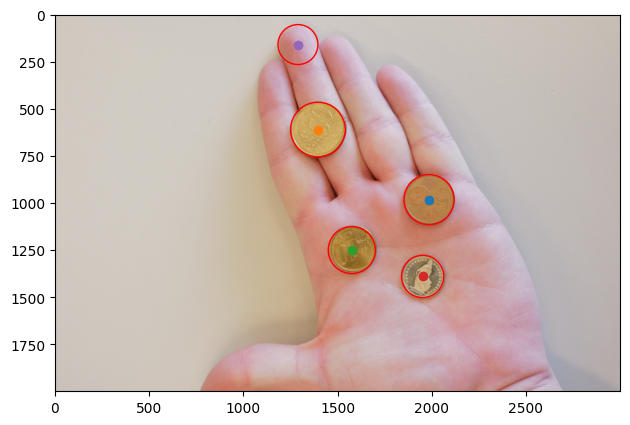

circles:  [array([1986,  982,  133], dtype=uint16), array([1396,  610,  145], dtype=uint16), array([1576, 1250,  125], dtype=uint16), array([1952, 1390,  112], dtype=uint16), array([1290,  159,  106], dtype=uint16)]
38 L1010388
(2000, 3000, 3)
[[[1485.       1279.5       197.39107 ]
  [1918.5      1107.        135.4093  ]
  [2070.       1492.5       124.167564]
  [1344.        634.5       182.79488 ]]]
circles:  [array([1485, 1280,  197], dtype=uint16), array([1918, 1107,  135], dtype=uint16), array([2070, 1492,  124], dtype=uint16), array([1344,  634,  183], dtype=uint16)]


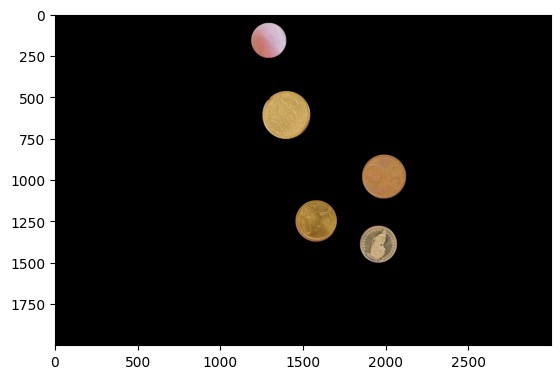

<Figure size 640x480 with 0 Axes>

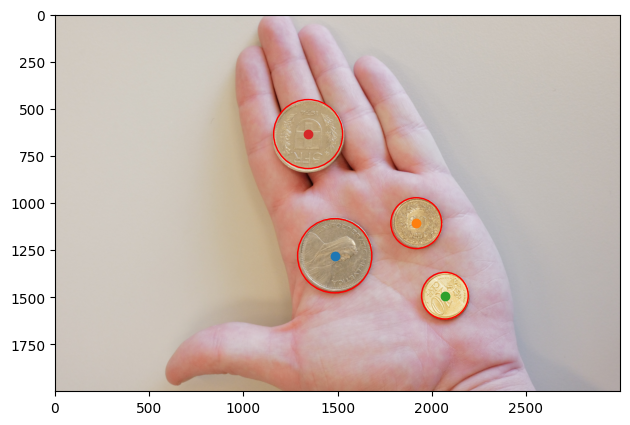

circles:  [array([1485, 1280,  197], dtype=uint16), array([1918, 1107,  135], dtype=uint16), array([2070, 1492,  124], dtype=uint16), array([1344,  634,  183], dtype=uint16)]
77 L1010506
(2000, 3000, 3)
[[[1447.5     1356.       200.07767]
  [1467.       978.       168.60237]
  [1168.5     1054.5      117.38407]]]
circles:  [array([1448, 1356,  200], dtype=uint16), array([1467,  978,  169], dtype=uint16), array([1168, 1054,  117], dtype=uint16)]


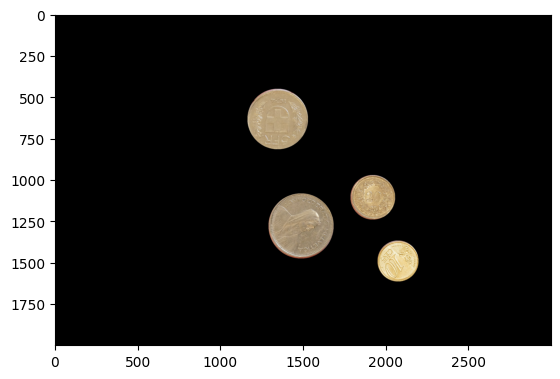

<Figure size 640x480 with 0 Axes>

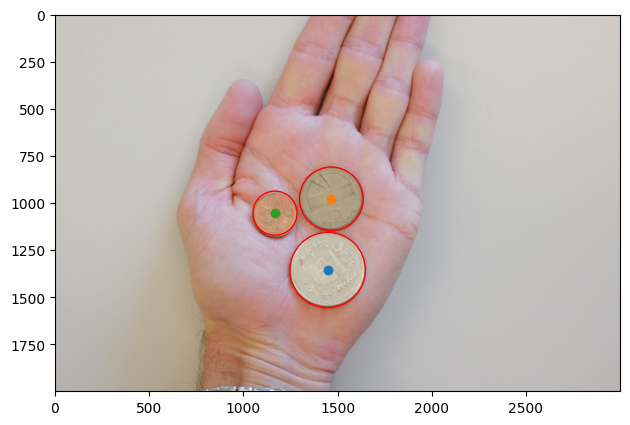

circles:  [array([1448, 1356,  200], dtype=uint16), array([1467,  978,  169], dtype=uint16), array([1168, 1054,  117], dtype=uint16)]
78 L1010521
(2000, 3000, 3)
[[[1750.5      625.5      194.10805]
  [1588.5     1170.       167.18362]
  [1353.       963.       152.05397]]]
circles:  [array([1750,  626,  194], dtype=uint16), array([1588, 1170,  167], dtype=uint16), array([1353,  963,  152], dtype=uint16)]


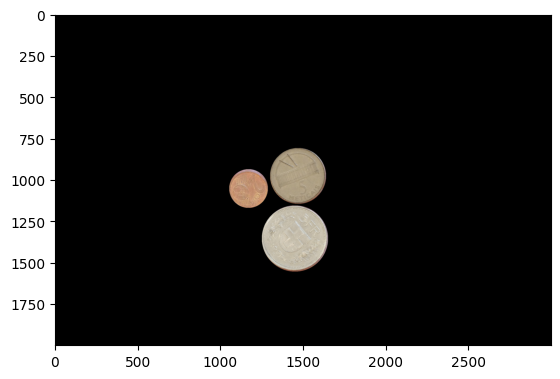

<Figure size 640x480 with 0 Axes>

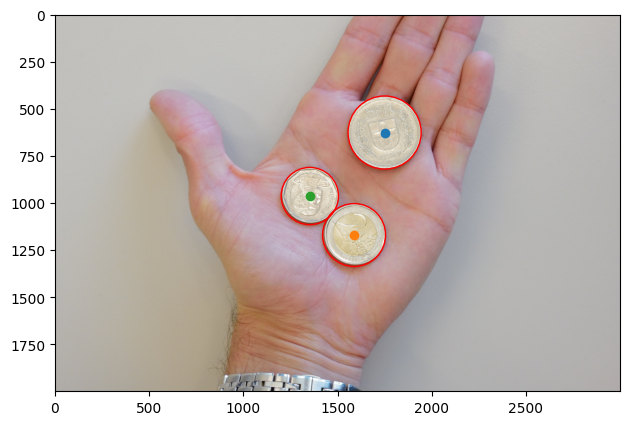

circles:  [array([1750,  626,  194], dtype=uint16), array([1588, 1170,  167], dtype=uint16), array([1353,  963,  152], dtype=uint16)]
79 L1010515
(2000, 3000, 3)
[[[1555.5     1060.5      164.69606]
  [1735.5      756.       156.72092]
  [1375.5      745.5      119.9861 ]
  [1122.       276.        91.88689]]]
circles:  [array([1556, 1060,  165], dtype=uint16), array([1736,  756,  157], dtype=uint16), array([1376,  746,  120], dtype=uint16), array([1122,  276,   92], dtype=uint16)]


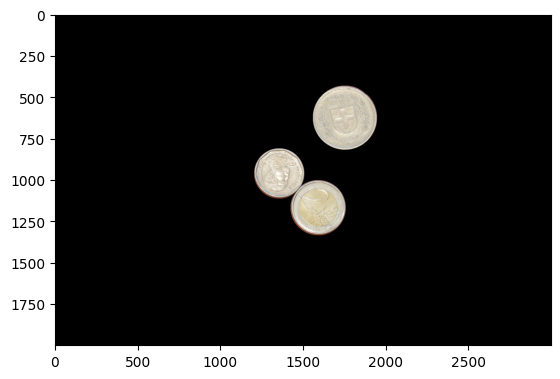

<Figure size 640x480 with 0 Axes>

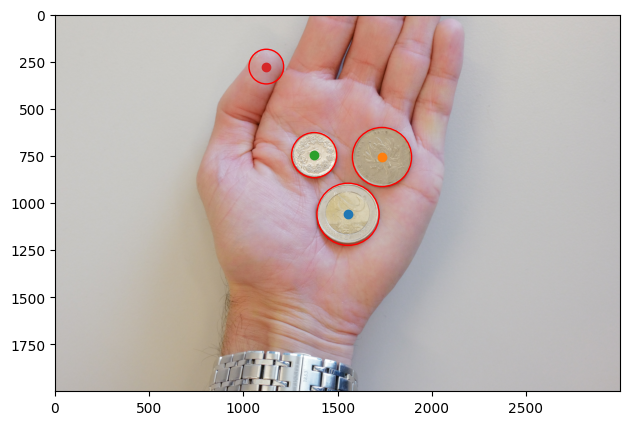

circles:  [array([1556, 1060,  165], dtype=uint16), array([1736,  756,  157], dtype=uint16), array([1376,  746,  120], dtype=uint16), array([1122,  276,   92], dtype=uint16)]


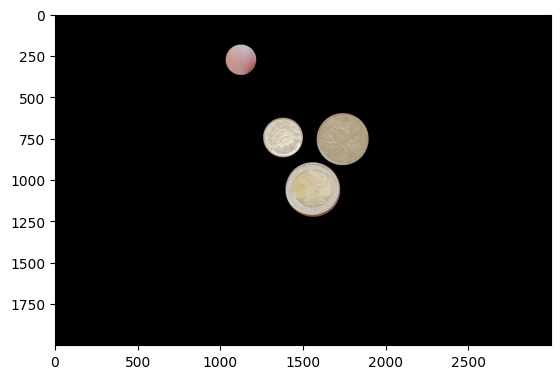

In [33]:
import random
list = random.sample(range(0,80),10)
print(list)
list = [25, 29, 31, 32, 38, 77, 78, 79]
# list=[0,1]
for i in list:
    print(i, coin_dataset.labels.iloc[i, 0])
    circles = plot_coins(img=coin_dataset[i]['image'], func=get_circles, title="Coins")
    print("circles: ", circles)

    mask = np.zeros(coin_dataset[i]['image'].shape[:2], dtype=np.uint8)
    for j in range(len(circles)):
        current_circle = circles[j]
        rr, cc = skimage.draw.disk(current_circle[0:2][::-1], current_circle[2], shape=coin_dataset[i]['image'].shape[:2])
        mask[rr, cc] = 1

    mask_3d = np.stack([mask] * 3, axis=-1)
    masked_image = mask_3d * coin_dataset[i]['image']
    plt.imshow(masked_image)

    patches = crop_image_into_patches(masked_image, circles = circles)
    for p in range(len(patches)):                                     # saving the cropped images
        cv2.imwrite(f'cropped_{i}_{p}.jpg', cv2.cvtColor(patches[p], cv2.COLOR_RGB2BGR))    
